# This notebook is intended to plot maps of O2 and CO2 fluxes, their ratio, and biotic and abiotic CO2 fluxes and their ratio

## Steps: 
- use intake-esm to read available model output into xarray datasets
- loop through models, using groupby seas to get DFJ average fluxes and write/read to nc to speed up plotting
- create multipanel plot

## Future to dos:
- look at fgco2abio, and fgco2-fgco2abio, and their ratio
- estimate N2 fluxes from SST, SSS, and heat flux to adjust O2 fluxes to match flux impact on atmospheric d(O2/N2)
- more models as they become available
- allow models missing r1 and just select the lowest ensemble of the ones available
- use OMIP1 and OMIP2 instead of historical to get common (reanalysis) forcing across models, and e.g. SO winds in the right place

### Setup:

In [1]:
%matplotlib inline

import xarray as xr
import intake
import util 
import os

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import cartopy.feature as cfeature

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


### Get collection of models using Intake-ESM:

In [2]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
#col

### Check collection columns:

In [3]:
col.df.columns

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'dcpp_init_year',
       'version', 'time_range', 'path'],
      dtype='object')

### Check unique models ("source_id"), experiments ("experiment_id") and temporal frequencies ("table_id"):

In [4]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

### Find all the O2 and CO2 flux data at monthly frequency from the ocean for the `historical` experiment. 

In [5]:
cat = col.search(experiment_id='historical', table_id='Omon', grid_label='gn', variable_id=['fgo2','fgco2'])
#cat.df
#Note: NorESM2 files are 10 years each, so there are many of these:

### Select only the models from historical simulation that have *both* `fgo2` and `fgco2` data. 
#### Selecting only the r1 ensemble member, which is excluding 2 models that have multiple ensemble members but no r1 (show up eventually?)

In [6]:
models = set(uni_dict['source_id']['values']) # all the models

#for variable_id in ['fgo2', 'fgco2', 'fgco2abio', 'fgco2nat', 'tos', 'sos', 'hfds']:
for variable_id in ['fgo2', 'fgco2']:
    query = dict(variable_id=variable_id, experiment_id='historical', table_id='Omon', 
                 grid_label='gn', member_id='r1i1p1f1')  
    ## we would get more models if we did not restrict to r1 (some models missing the first ensemble member)
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

# ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
models = models - {'CESM2-WACCM', 'CESM2'} # tested just to look at without , 'NorESM2-LM'}

models = list(models)
models

['NorESM2-LM', 'IPSL-CM6A-LR', 'CanESM5']

### Make a catalog of files corresponding to these models and variables:

In [7]:
cat = col.search(experiment_id='historical', variable_id=['fgo2', 'fgco2'], table_id='Omon', 
                 grid_label='gn', source_id=models, member_id='r1i1p1f1')
#cat.df
#cat.df.path.tolist()

### Create a dictionary of output using intake-esm:

In [8]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {'time': 36}, 'decode_times': True})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 3 group(s)


`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [9]:
dset_dict.keys()

dict_keys(['CMIP.CCCma.CanESM5.historical.Omon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn', 'CMIP.NCC.NorESM2-LM.historical.Omon.gn'])

### Manually hack in coordinate variable names

In [10]:
latitudevars={'CMIP.CCCma.CanESM5.historical.Omon.gn': 'latitude', 
              'CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn': 'nav_lat','CMIP.NCC.NorESM2-LM.historical.Omon.gn' : 'latitude'}
longitudevars={'CMIP.CCCma.CanESM5.historical.Omon.gn': 'longitude', 
              'CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn': 'nav_lon','CMIP.NCC.NorESM2-LM.historical.Omon.gn' : 'longitude'}

### Loop on models, calculate DJF average fluxes, and write out to small netcdf files and read back in to speed up plotting, and collect into a dictionary

In [11]:
multimoddjf={} # dictionary
for k in dset_dict.keys():
    print(k)
    ds=dset_dict[k]
    da=ds['fgo2']
    # make DJf average
    ### to do: select most recent decade
    ### to do: do co2 too
    djf=da.groupby('time.season').mean('time').sel(season='DJF')
    dsout = djf.to_dataset().squeeze()
    da=ds['fgco2']
    #print(da)
    djf=da.groupby('time.season').mean('time').sel(season='DJF')
    dsout['fgco2'] = djf.squeeze() 
    dsout['latitude'] = dset_dict[k][latitudevars[k]]
    dsout['longitude'] = dset_dict[k][longitudevars[k]]
    print(dset_dict[k].source_id)
    dsout.attrs['model'] = dset_dict[k].source_id
    ### add CO2 and others here
    #os.remove('so_o2_co2_flux_files/'+k+'.nc')  # if crashes, have to manually remove these files at command line before rerunning
    dsout.to_netcdf('so_o2_co2_flux_files/'+k+'.nc')
    dsin = xr.open_dataset('so_o2_co2_flux_files/'+k+'.nc') 
    multimoddjf[k]=dsin
    dsin.close()

CMIP.CCCma.CanESM5.historical.Omon.gn
CanESM5


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn
IPSL-CM6A-LR


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CMIP.NCC.NorESM2-LM.historical.Omon.gn
NorESM2-LM


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Correct NorESM for it having flipped fluxes

In [12]:
multimoddjf['CMIP.NCC.NorESM2-LM.historical.Omon.gn']['fgo2']*=-1
multimoddjf['CMIP.NCC.NorESM2-LM.historical.Omon.gn']['fgco2']*=-1

Make plots

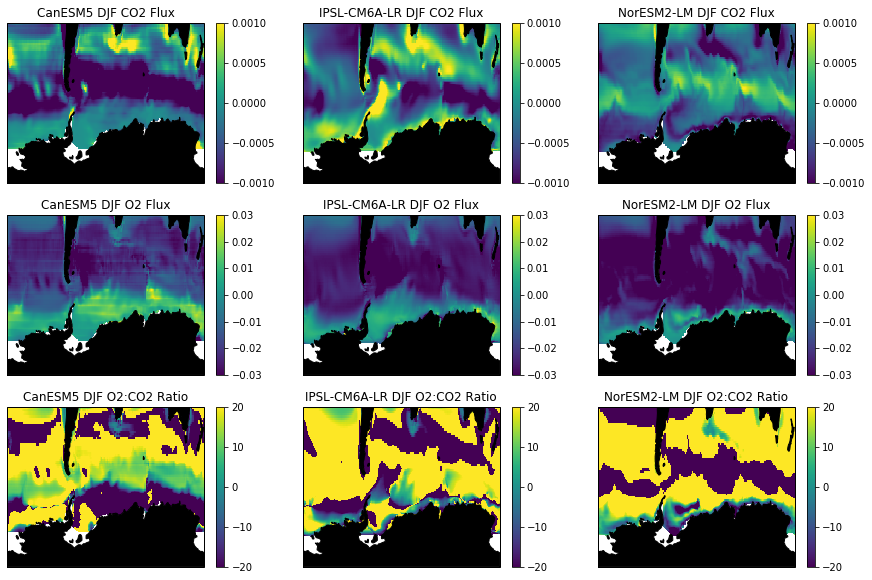

In [21]:
#To Do:
# get polar stereo working
# only need color bar once per row
# add axis values?
# add units

#f, axs = plt.subplots(ncols=3, nrows=2, subplot_kw=dict(projection=ccrs.SouthPolarStereo()),figsize=(15,10)) ## not working for some reason
f, axs = plt.subplots(ncols=3, nrows=3, subplot_kw=dict(projection=ccrs.PlateCarree()),figsize=(15,10))
for ax, (k, v) in zip(axs.ravel()[0:3], multimoddjf.items()):
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    tmp=ax.pcolormesh(v.longitude, v.latitude, v.fgco2*1000/44*86400, transform=ccrs.PlateCarree(), vmin=-1E-3, vmax=1E-3) #molCO2/m2/day
    ax.set_aspect('auto')
    ax.add_feature(cfeature.LAND, color='k',zorder=4)
    ax.set_title(v.model+' DJF CO2 Flux')
    #ax.set_xlabel('longitude')
    #ax.set_ylabel('latitude')
    f.colorbar(tmp,ax=ax)
    
for ax, (k, v) in zip(axs.ravel()[3:6], multimoddjf.items()):
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    tmp=ax.pcolormesh(v.longitude, v.latitude, v.fgo2*86400, transform=ccrs.PlateCarree(), vmin=-0.03, vmax=0.03) # mol/m2/day
    ax.set_aspect('auto')
    ax.add_feature(cfeature.LAND, color='k',zorder=4)
    ax.set_title(v.model+' DJF O2 Flux')
    #ax.set_xlabel('longitude')
    #ax.set_ylabel('latitude')
    f.colorbar(tmp,ax=ax)
    
for ax, (k, v) in zip(axs.ravel()[6:9], multimoddjf.items()):
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    tmp=ax.pcolormesh(v.longitude, v.latitude, v.fgo2/(v.fgco2*1000/44), transform=ccrs.PlateCarree(), vmin=-20, vmax=20)
    ax.set_aspect('auto')
    ax.add_feature(cfeature.LAND, color='k',zorder=4)
    ax.set_title(v.model+' DJF O2:CO2 Ratio')
    f.colorbar(tmp,ax=ax)
